In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("projB1.ipynb")

# Project B1: Spam/Ham Classification

## Due Date: Thursday, April 18th at 11:59 PM

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 18th, 11:59 PM. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for submission support. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully when submitting your work to Gradescope. 

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
You will use what you've learned in class to create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data.
- Using the `sklearn` library to process data and fit models.
- Validating the performance of your model and minimizing overfitting.

This first part of the project focuses on initial analysis, feature engineering, and logistic regression. In the second part of this project (which will be released next week), you will build your own spam/ham classifier.

## Content Warning
This is a **real-world** dataset —— the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these inappropriate emails but wanted to provide a warning at the beginning of the project so that you are aware.

If you feel uncomfortable with this topic, **please contact your TA, the instructors, or reach out via the [Spring 2024 extenuating circumstances form](https://forms.gle/HFdpmHzBu1e7zcF2A).**

In [2]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


**Don't worry about the note stating you may need to restart the kernel to use updated packages. Feel free to ignore that.**

## Grading
Grading is broken down into autograded answers and free responses. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1 | Yes | 2
2 | No | 3
3 | Yes | 3
4 | No | 2
5 | No | 2
6a | No | 1
6b | No | 1
6c | Yes | 2
6d | No | 2
6e | No | 1
6f | Yes | 1
6g | Yes | 1
6h | Yes | 2
Total | 6 | 23

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process towards reaching your final answer. If you happen to create new cells below your answer to run code, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

### Debugging Guide
If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, common `pandas` errors, RegEx, visualizations, and more.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2024.

Run the following cells to load the data into a `DataFrame`.

The `train` `DataFrame` contains labeled data you will use to train your model. It has four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` `DataFrame` contains 1,000 unlabeled emails. In Project B2, you will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


<br/>

First, let's check if our data contains any missing values. We have filled in the cell below to print the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [6]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [7]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



<!-- BEGIN QUESTION -->

<br>

---

## Question 1

Discuss one attribute or characteristic you notice that is different between the two emails that may allow you to uniquely identify a spam email.

The Spam email is in HTML form, whereas the Ham email looks more like it is written in a more regular format. Spam emails may be more likely to come in HTML code for mass emailing, whereas regular emails will be written in a more humanoid format because they are only meant to be sent out once.

<!-- END QUESTION -->

## Training-Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We, therefore, need to split the training data into separate training and validation datasets. You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (`random_state`) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this random seed in the following questions, as our tests depend on it.**

In [8]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

In [9]:
train.head()

,id,subject,email,spam
7657,7657,Subject: Patch to enable/disable log\n,"while i was playing with the past issues, it a...",0
6911,6911,Subject: When an engineer flaps his wings\n,url: http://diveintomark.org/archives/2002/10/...,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"no, please post a link!\n \n fox\n ----- origi...",0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,this article from nytimes.com \n has been sent...,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>tech update today</ti...,0


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Feature Engineering

We want to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

<br>

---

## Question 2

Create a function `words_in_texts` that takes in a list of interesting words (`words`) and a `Series` of emails (`texts`). Our goal is to check if each word in `words` is contained in the emails in `texts`.

The `words_in_texts` function should output a **2-dimensional `NumPy` array** that contains one row for each email in `texts` and one column for each word in `words`. If the $j$-th word in `words` is present at least once in the $i$-th email in `texts`, the output array should have a value of 1 at the position $(i, j)$. Otherwise, if the $j$-th word is not present in the $i$-th email, the value at $(i, j)$ should be 0.

In Project B2, we will be applying `words_in_texts` to some large datasets, so implementing some form of vectorization (for example, using `NumPy` arrays, `Series.str` functions, etc.) is highly recommended. **You are allowed to use only *one* list comprehension or for loop**, and you should look into how you could combine that with the vectorized functions discussed above. **Do not use a double for loop, or you will run into issues later on in Project B2.**

For example:
```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

Importantly, we **do not** calculate the *number of occurrences* of each word; only if the word is present at least *once*. Take a moment to work through the example on your own if need be —— understanding what the function does is a critical first step in implementing it.

*The provided tests make sure that your function works correctly so that you can use it for future questions.*

In [10]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """
    indicator_array = np.array([texts.str.contains(word).astype(int) for word in words]).T
    return indicator_array
    
    # return texts.str.contains(words[0]).astype(int)

In [11]:
# Run this cell to see what your function outputs. Compare the results to the example provided above.
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [12]:
grader.check("q2")

q2 results: All test cases passed!

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. Suppose the feature is a binary indicator, such as whether a particular word occurs in the text. In that case, this compares the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. The bars colored by email class were generated by setting the `hue` parameter of `sns.barplot` to a column containing the class (spam or ham) of each data point. An example of how this class column was created is shown below:

![training conditional proportions](images/training_conditional_proportions.png)

You can use `DataFrame`'s `.melt` ([documentation](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.melt.html)) method to "unpivot" a `DataFrame`. See the following code cell for an example.

In [13]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column."))
display(df.melt("type"))

> Our original `DataFrame` has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurrences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the `value` column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<br>

---

## Question 3

Create the bar chart above by comparing the proportion of spam and ham emails containing specific words. **Choose a set of 6 words other than those shown in the example.** These words should have different proportions for the two classes (i.e., noticeably different bar heights across spam and ham). Make sure only to consider emails from `train`. Your `words_in_texts` function from the previous part will be useful here. 

**Hint:** This is a pretty challenging question. The suggested approach is to first look at the example bar plot and make sure you can interpret what is being plotted - what does a bar represent? What does the height mean? 

Next, see how to make this plot with `sns.barplot`. Take a look at the [documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html) and determine what the inputs should be. A possible data input is given below:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>type</th>      <th>variable</th>      <th>value</th>    </tr>  </thead>  <tbody>    
<tr>      <th>0</th>      <td>Ham</td>      <td>word_1</td>      <td>0.021269</td>    </tr>    
<tr>      <th>1</th>      <td>Ham</td>      <td>word_2</td>      <td>0.101519</td>    </tr>    
<tr>      <th>2</th>      <td>Spam</td>      <td>word_3</td>      <td>0.059160</td>    </tr>    
<tr>      <th>3</th>      <td>Spam</td>      <td>word_2</td>      <td>0.017694</td>    </tr>    
<tr>      <th>4</th>      <td>Ham</td>      <td>word_4</td>      <td>0.013226</td>    </tr>     
<tr>      <th>...</th>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>    
</tbody></table>

Finally, you will need to chain some `pandas` functions together. Try to add one function at a time and see how that affects the `DataFrame`. It may help to use a new cell or print out the `DataFrame` for debugging purposes as you work towards achieving the desired format above.

<!-- BEGIN QUESTION -->

Create your bar chart in the following cell:

In [14]:
# Want to generate the proportion of ham/spam emails that contain the word. 
# First, sum up the number of emails where the word is found, then divide by the total number of emails in that category
# np.sum along the index axis (sum the columns, not rows) because each column from the output of words_in_texts
# are the occurrences for that word. 
spam_words = ['href', 'free', 'act', 'congratulations', 'debt', 'income']

# all_ham_emails = original_training_data.loc[original_training_data['spam'] == 0, 'email']
train_ham_emails = train.loc[train['spam'] == 0, 'email']
train_spam_emails = train.loc[train['spam'] == 1, 'email']

In [15]:
print(len(all_ham_emails))
print(len(train_ham_emails))

6208
5595


In [16]:
words_in_ham = words_in_texts(spam_words, train_ham_emails)
summed_ham_words = np.sum(words_in_ham, axis=0)
summed_ham_words

array([ 326, 1729, 2194,   15,   33,   63])

In [18]:
words_in_spam = words_in_texts(spam_words, train_spam_emails)
summed_spam_words = np.sum(words_in_spam, axis=0)
summed_spam_words

array([ 976,  943, 1054,   41,  140,  170])

In [19]:
prop_ham_words = summed_ham_words / len(train_ham_emails)
prop_spam_words = summed_spam_words / len(train_spam_emails)
print(prop_ham_words, prop_spam_words)

[0.05826631 0.30902592 0.39213584 0.00268097 0.00589812 0.01126005] [0.5088634  0.49165798 0.54953076 0.02137643 0.0729927  0.08863399]


In [20]:
ham_df = pd.DataFrame(prop_ham_words.reshape(1, -1), columns=spam_words)
ham_df['type'] = 'Ham'
ham_df

,href,free,act,congratulations,debt,income,type
0,0.058266,0.309026,0.392136,0.002681,0.005898,0.01126,Ham


In [21]:
spam_df = pd.DataFrame(prop_spam_words.reshape(1, -1), columns=spam_words)
spam_df['type'] = 'Spam'
spam_df

,href,free,act,congratulations,debt,income,type
0,0.508863,0.491658,0.549531,0.021376,0.072993,0.088634,Spam


In [22]:
spam_ham_df = pd.concat([ham_df, spam_df]).melt('type')
spam_ham_df

,type,variable,value
0,Ham,href,0.058266
1,Spam,href,0.508863
2,Ham,free,0.309026
3,Spam,free,0.491658
4,Ham,act,0.392136
5,Spam,act,0.549531
6,Ham,congratulations,0.002681
7,Spam,congratulations,0.021376
8,Ham,debt,0.005898
9,Spam,debt,0.072993


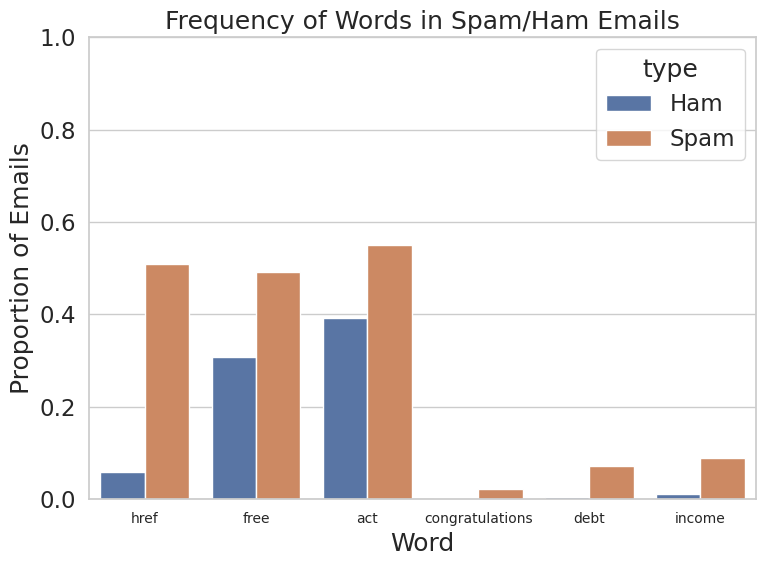

In [23]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))
sns.barplot(data=spam_ham_df, x='variable', y='value', hue='type')

ax = plt.gca()
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of Emails')

ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xlabel('Word')

plt.title('Frequency of Words in Spam/Ham Emails')

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

<br>

---

## Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words and the `train` `DataFrame` to create two `NumPy` arrays: `X_train` and `Y_train`. `X_train` should be a 2D array of 0s and 1s created using your `words_in_texts` function on all the emails in the training set. `Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your design matrix ($\mathbb{X}$) are correct and that your features and labels are binary (i.e., consist only of 0s and 1s). It does not check that your function is correct; that was verified in Question 2.*

In [24]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam'].to_numpy()

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [25]:
grader.check("q4")

q4 results: All test cases passed!

<br>

---
## Question 5

Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.76$.

*The provided tests check that you initialized your logistic regression model correctly.*

In [26]:
from sklearn.linear_model import LogisticRegression

my_model = LogisticRegression().fit(X_train, Y_train)
X_train_predictions = my_model.predict(X_train)

training_accuracy = np.sum(X_train_predictions == Y_train) / len(X_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [27]:
grader.check("q5")

q5 results: All test cases passed!

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 5: Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating the accuracy of the model on the training set, which may be a misleading measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will make use of the data we held out for model validation and comparison.

Presumably, our classifier will be used for **filtering**, or preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier in addition to overall accuracy:

**Precision**: Measures the proportion of emails flagged as spam that are actually spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FP}}$.

**Recall**: Measures the proportion  of spam emails that were correctly flagged as spam. Mathematically, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

**False positive rate**: Measures the proportion  of ham emails that were incorrectly flagged as spam. Mathematically, $\frac{\text{FP}}{\text{FP} + \text{TN}}$.

One quick mnemonic to remember the formulas is that **P**recision involves T**P** and F**P**, Recall does not. In the final, the reference sheet will also contain the formulas shown above, but you should be able to interpret what they mean and their importance depending on the context.

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="images/precision_recall.png" width="600px" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br>

---

## Question 6a

Suppose we have a hypothetical classifier called the “zero predictor.” For any inputted email, the zero predictor *always* predicts 0 (it never makes a prediction of 1 for any email). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Assign `zero_predictor_fp` to the number of false positives and `zero_predictor_fn` to the number of false negatives for the hypothetical zero predictor on the training data.

*The public tests only check that you have assigned appropriate types of values to each response variable but do not check that your answers are correct. That is, we only check that the number of false positives and false negatives should be greater than or equal to 0.*

In [30]:
zero_predictor_fp = 0
zero_predictor_fn = np.sum(train['spam'] == 1)
zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [32]:
grader.check("q6a")

q6a results: All test cases passed!

<br>

---

## Question 6b

What is the accuracy and recall of the zero predictor on the training data? Do not use any `sklearn` functions to compute these performance metrics.

*The public tests only check that you have assigned appropriate types of values to each response variable but do not check that your answers are correct. That is, we only check that proportions or percentages (like precision, recall, accuracy) lie in the interval [0, 1].*

In [34]:
zero_predictor_acc = np.sum(train['spam']==0) / len(train['spam'])
zero_predictor_recall = 0
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0)

In [35]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

## Question 6c

Explain your results in `q6a` and `q6b`. How did you know what to assign to `zero_predictor_fp`, `zero_predictor_fn`, `zero_predictor_acc`, and `zero_predictor_recall`?

Because the zero predictor only ever classifies emails as zeroes/Ham/Negative, that means that none of the emails are classified as 1/Spam/**Positive**. Therefore, the number of True Positives *and* False Positives is 0. Therefore, `zero_predictor_fp = 0`. Because recall relies on the number of True Positives in the numerator, it is also true that `zero_predictor_recall = 0`.

For false negatives, since zero_predictor only classifies emails as negatives, the only *false* negatives are the emails that are actually spam. Therefore, the number of false negatives are the number of emails in the dataset that have the true classification of spam.

Finally, the accuracy remains still as the number of labels that the zero_predictor predicted correctly. Since the zero_predictor only predicts 0's, the correct predictions are for the emails whose true labels are zero. Therefore, it is the number of labels in the training set that are actually Ham divided by the total number of emails, ie. the proportion of emails that are actually Ham in the training set.

<!-- END QUESTION -->

<br/>

---

## Question 6d

Compute the precision, recall, and false positive rate of the `LogisticRegression` classifier `my_model` from Question 5. Do **not** use any `sklearn` functions to compute performance metrics; the only `sklearn` method you may use here is `.predict` to generate model predictions using `my_model` and `X_train`.

*The public tests only check that you have assigned appropriate types of values to each response variable but do not check that your answers are correct. That is, we only check that proportions or percentages (like precision, recall, false positive rate) lie in the interval [0, 1].*

In [46]:
Y_train_hat = my_model.predict(X_train)

TP = np.sum((Y_train_hat == 1) & (Y_train_hat == Y_train))
TN = np.sum((Y_train_hat == 0) & (Y_train_hat == Y_train))
FP = np.sum((Y_train_hat == 1) & (Y_train_hat != Y_train))
FN = np.sum((Y_train_hat == 0) & (Y_train_hat != Y_train))
logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_fpr = FP / (FP + TN)

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
assert(TP + TN + FP + FN == len(Y_train))
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=219, TN=5473, FP=122, FN=1699
logistic_predictor_precision=0.64, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02


In [49]:
logistic_predictor_accuracy = np.sum((Y_train_hat == Y_train)) / len(Y_train)
logistic_predictor_accuracy

0.7576201251164648

In [47]:
grader.check("q6d")

q6d results: All test cases passed!

<br>

---

## Question 6e

Is the number of false positives produced by the logistic regression classifier `my_model` strictly greater than the number of false negatives produced? Assign to `q6e` an expression that evaluates to give your answer (`True` or `False`). 

In [41]:
q6e = False
q6e

False

In [42]:
grader.check("q6e")

q6e results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

## Question 6f

How does the accuracy of the logistic regression classifier `my_model` compare to the accuracy of the zero predictor?

In [51]:
logistic_predictor_accuracy = np.sum((Y_train_hat == Y_train)) / len(Y_train)
print(f'logistic_predictor_accuracy: {logistic_predictor_accuracy}, zero_predictor_accuracy: {zero_predictor_acc}')
print(logistic_predictor_accuracy - zero_predictor_acc)

logistic_predictor_accuracy: 0.7576201251164648, zero_predictor_accuracy: 0.7447091707706642
0.012910954345800585


The accuracy of my_model is only slightly greater than the zero_predictor. my_model has an accuracy of 75.76%, while the zero_predictor has an accuracy of 74.47%. Thus, the logistic predictor only has a greater accuracy of 1.29%, which seems relatively minimal, considering our logistic predictor should in theory be better than just never classifying an email as spam. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6g

Given the word features provided in Question 4, discuss why the logistic regression classifier `my_model` may be performing poorly. 

**Hint:** Think about how prevalent these words are in the email set.

In [52]:
some_words

['drug', 'bank', 'prescription', 'memo', 'private']

In [56]:
some_words_in_ham = words_in_texts(some_words, train_ham_emails)
summed_ham_some_words = np.sum(some_words_in_ham, axis=0)
some_words_in_spam = words_in_texts(some_words, train_spam_emails)
summed_spam_some_words = np.sum(some_words_in_spam, axis=0)
prop_ham_some_words = summed_ham_some_words / len(train_ham_emails)
prop_spam_some_words = summed_spam_some_words / len(train_spam_emails)
some_words_ham_df = pd.DataFrame(prop_ham_some_words.reshape(1, -1), columns=some_words)
some_words_ham_df['type'] = 'Ham'
some_words_spam_df = pd.DataFrame(prop_spam_some_words.reshape(1, -1), columns=some_words)
some_words_spam_df['type'] = 'Spam'
somewords_df = pd.concat([some_words_ham_df, some_words_spam_df]).melt('type')
somewords_df

,type,variable,value
0,Ham,drug,0.010366
1,Spam,drug,0.033368
2,Ham,bank,0.021269
3,Spam,bank,0.097497
4,Ham,prescription,0.001609
5,Spam,prescription,0.023983
6,Ham,memo,0.044861
7,Spam,memo,0.030761
8,Ham,private,0.026631
9,Spam,private,0.082899


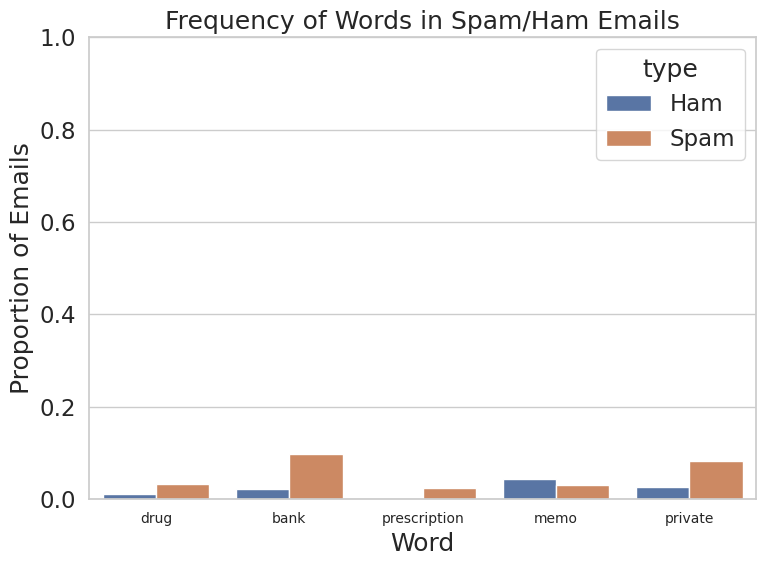

In [57]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts.
plt.figure(figsize=(8,6))
sns.barplot(data=somewords_df, x='variable', y='value', hue='type')

ax = plt.gca()
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of Emails')

ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xlabel('Word')

plt.title('Frequency of Words in Spam/Ham Emails')

plt.tight_layout()
plt.show()

When thinking about the prevalence of these words in an email, the graph alludes that they are not very prevalent. In regular Ham emails, these words appear very infrequently. Even in the Spam emails, the most prevalent word only appears in about 10% of the spam emails, with multiple words appearing much less. Thus, the words chosen for feature engineering for emails may not be optimal and may not be the best for the distribution of emails in our dataset, given that they show such little prevalence in both Ham and Spam emails. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

---

## Question 6h

Would you prefer to use the logistic regression classifier `my_model` or the zero predictor classifier for a spam filter? Why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

Given the nature of this problem, I would rather use the zero predictor. This is because the zero predictor has a similar accuracy as the logistic regression classifier while also zero false positives, which could be critical when dealing with emails. I would not want an important email to be misclassified as a spam email (false positive) with only a ~1% increase in accuracy when actually filtering out spam. 

Thus, I would rather all emails be not marked at spam and have to filter out the spam manually than have to potentially look through the "Spam" folder for an actually important email that was misclassified.

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Nori and Ella congratulate you for finishing Project B1!
<div align="middle">
    <table style="width:100%">
      <tr align="center">
        <td><video controls src = "images/nori_snow.MP4" width = "250">animation</video>
        </td>
        <td><img src="images/ella.png" align="middle" width="325vw" />
      </tr>
    </table>
  </div>

What's next? In Project B2, you will focus on building a spam/ham email classifier with logistic regression. You will be well-prepared to build such a model: you have considered what is in this data set, what it can be used for, and engineered some features that should be useful for prediction.

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly, weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://docs.google.com/forms/d/e/1FAIpQLSe0fBEJwt6aEfZxU3fh3llNk8rSWHj6Umq0km3wPqmFu0MlGA/viewform). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Once you submit this file to the Project B1 Coding assignment on Gradescope, Gradescope will automatically submit a PDF file with your written answers to the Project B1 Written assignment. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

If there are issues with automatically generating the PDF, please check this [section](https://ds100.org/debugging-guide/jupyter_datahub/jupyter_datahub.html#i-cant-export-my-assignment-as-a-pdf-due-to-a-latexfailed-error) of the Debugging Guide for alternative options.

**You are responsible for ensuring your submission follows our requirements and that everything was generated and submitted correctly. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline. 

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [58]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q2 results: All test cases passed!

    q4 results: All test cases passed!

    q5 results: All test cases passed!

    q6a results: All test cases passed!

    q6b results: All test cases passed!

    q6d results: All test cases passed!

    q6e results: All test cases passed!
